In [46]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
from tqdm import tqdm
import os
import csv

import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold, cross_val_predict
import geopandas as gpd

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.neural_network import MLPRegressor
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import matplotlib.gridspec as gridspec

from deforestutils import *

from joblib import dump, load
from joblib import Parallel, delayed


In [42]:

def create_path(path_string):
    if not os.path.exists(path_string):
        os.makedirs(path_string)


def setup_directory(FOLDER_NAME):
    paths_to_create = [ f'FeatureImportanceResults/{FOLDER_NAME}', 
                        f'FeatureImportanceResults/{FOLDER_NAME}/TestTrainIndices'
                        f'FeatureImportanceResults/{FOLDER_NAME}/TestTrainIndices/TestTrainSplit', 
                        f'FeatureImportanceResults/{FOLDER_NAME}/TestTrainIndices/CrossValidation', 
                        f'FeatureImportanceResults/{FOLDER_NAME}/PredictedDeforestation', 
                        f'FeatureImportanceResults/{FOLDER_NAME}/ModelFits'
                        f'FeatureImportanceResults/TestTrainIndices', 
                        f'FeatureImportanceResults/TestTrainIndices/TestTrainSplit', 
                        f'FeatureImportanceResults/TestTrainIndices/CrossValidation',
                        f'FeatureImportanceResults/TestTrainIndices/Nulls', 
                        f'FeatureImportanceResults/{FOLDER_NAME}/TestTrainIndices/Nulls']

    for path in paths_to_create:
        create_path(path)

    with open(f'FeatureImportanceResults/{FOLDER_NAME}/performance.txt', 'w+') as f:
            f.write(f'MODEL PERFORMANCES\n')
    print('Files setup.')

def get_full_data(START_YEAR_TRAIN, YEARS_TO_TRAIN):
        df_full = pd.read_csv(f'FinalData/FinalData{START_YEAR_TRAIN}_1.csv')
        df_full = pd.concat([df_full, pd.read_csv(f'FinalData/FinalData{START_YEAR_TRAIN}_2.csv')])
        df_full = pd.concat([df_full, pd.read_csv(f'FinalData/FinalData{START_YEAR_TRAIN}_3.csv')])
        df_full = pd.concat([df_full, pd.read_csv(f'FinalData/FinalData{START_YEAR_TRAIN}_4.csv')])


        for year in YEARS_TO_TRAIN[1:]:
            filename = f'FinalData/FinalData{str(year)}_1.csv'
            df_full = pd.concat([df_full, pd.read_csv(filename)])
            filename = f'FinalData/FinalData{str(year)}_2.csv'
            df_full = pd.concat([df_full, pd.read_csv(filename)])
            filename = f'FinalData/FinalData{str(year)}_3.csv'
            df_full = pd.concat([df_full, pd.read_csv(filename)])
            filename = f'FinalData/FinalData{str(year)}_4.csv'
            df_full = pd.concat([df_full, pd.read_csv(filename)])

        print(f'Read in data for {START_YEAR_TRAIN}')
        print(f'Years in data: {np.unique(df_full.year)}')
        print(f'Number of rows in data: {df_full.shape}')
        return df_full
    

def get_x_cols():
    return ['year', 'rain1', 'elevation', 'slope', 'aspect', 'near_mines',
        'near_roads', 'near_hidrovia', 'indigenous_homol',
        'mun_election_year', 'new_forest_code', 'lula', 'dilma', 'temer',
        'bolsonaro', 'fed_election_year', 'populacao', 'pib_pc', 'ironore',
        'silver', 'copper', 'gold', 'soy_price', 'beef_price', 'ag_jobs',
        'mining_jobs', 'public_jobs', 'construction_jobs', 'PIB',
        'n_companies_PUBLIC ADMIN', 'n_companies_AGRICULTURE',
        'n_companies_FOOD AND DRINKS', 'n_companies_ACCOMODATION AND FOOD',
        'n_companies_EQUIPMENT RENTAL', 'n_companies_WHOLESALE',
        'n_companies_ASSOCIATIVE ACTIVITIES',
        'n_companies_AUTOMOBILES AND TRANSPORT',
        'n_companies_FINANCIAL ASSISTANCE',
        'n_companies_TRADE REP VEHICLES', 'n_companies_CONSTRUCTION',
        'n_companies_MAIL AND TELECOM', 'n_companies_CULTURE AND SPORT',
        'n_companies_EDITING AND PRINTING', 'n_companies_EDUCATION',
        'n_companies_ELECTRICITY AND GAS', 'n_companies_FINANCES',
        'n_companies_CLEANING AND SEWAGE', 'n_companies_MACHINERY',
        'n_companies_BASIC METALLURGY', 'n_companies_MINING',
        'n_companies_WOOD PROD',
        'n_companies_NON-METALLIC MINERAL PRODUCTS', 'n_companies_HEALTH',
        'n_companies_SERVICES FOR COMPANIES',
        'n_companies_PERSONAL SERVICES', 'n_companies_TRANSPORTATION',
        'n_companies_GROUND TRANSPORT',
        'n_companies_WATER TREATMENT AND DISTRIBUTION',
        'n_companies_RETAIL', 'n_companies_COMPUTING',
        'n_companies_INSURANCE AND SOCIAL SECURITY',
        'n_companies_METALLIC PRODUCTS', 'n_companies_DOMESTIC SERVICES',
        'n_companies_FORESTRY', 'n_companies_CLOTHING',
        'n_companies_PAPER', 'n_companies_INTERNATIONAL BODIES',
        'n_companies_OIL AND GAS', 'n_companies_FISHING AND AQUACULTURE',
        'n_companies_CHEMICALS', 'n_companies_WATER-BASED TRANSPORTATION',
        'n_companies_REAL ESTATE', 'n_companies_RECYCLING',
        'n_companies_LEATHERS AND FOOTWEAR',
        'n_companies_RUBBER AND PLASTIC', 'n_companies_TEXTILES',
        'n_companies_RESEARCH AND DEVELOPMENT',
        'n_companies_AERO TRANSPORT', 'n_companies_SMOKE',
        'n_companies_PETROLEUM REFINING', 'n_companies_',
        'n_jobs_PUBLIC ADMIN', 'n_jobs_AGRICULTURE',
        'n_jobs_FOOD AND DRINKS', 'n_jobs_ACCOMODATION AND FOOD',
        'n_jobs_EQUIPMENT RENTAL', 'n_jobs_WHOLESALE',
        'n_jobs_ASSOCIATIVE ACTIVITIES',
        'n_jobs_AUTOMOBILES AND TRANSPORT', 'n_jobs_FINANCIAL ASSISTANCE',
        'n_jobs_TRADE REP VEHICLES', 'n_jobs_CONSTRUCTION',
        'n_jobs_MAIL AND TELECOM', 'n_jobs_CULTURE AND SPORT',
        'n_jobs_EDITING AND PRINTING', 'n_jobs_EDUCATION',
        'n_jobs_ELECTRICITY AND GAS', 'n_jobs_FINANCES',
        'n_jobs_CLEANING AND SEWAGE', 'n_jobs_MACHINERY',
        'n_jobs_BASIC METALLURGY', 'n_jobs_MINING', 'n_jobs_WOOD PROD',
        'n_jobs_NON-METALLIC MINERAL PRODUCTS', 'n_jobs_HEALTH',
        'n_jobs_SERVICES FOR COMPANIES', 'n_jobs_PERSONAL SERVICES',
        'n_jobs_TRANSPORTATION', 'n_jobs_GROUND TRANSPORT',
        'n_jobs_WATER TREATMENT AND DISTRIBUTION', 'n_jobs_RETAIL',
        'n_jobs_COMPUTING', 'n_jobs_INSURANCE AND SOCIAL SECURITY',
        'n_jobs_METALLIC PRODUCTS', 'n_jobs_DOMESTIC SERVICES',
        'n_jobs_FORESTRY', 'n_jobs_CLOTHING', 'n_jobs_PAPER',
        'n_jobs_INTERNATIONAL BODIES', 'n_jobs_OIL AND GAS',
        'n_jobs_FISHING AND AQUACULTURE', 'n_jobs_CHEMICALS',
        'n_jobs_WATER-BASED TRANSPORTATION', 'n_jobs_REAL ESTATE',
        'n_jobs_RECYCLING', 'n_jobs_LEATHERS AND FOOTWEAR',
        'n_jobs_RUBBER AND PLASTIC', 'n_jobs_TEXTILES',
        'n_jobs_RESEARCH AND DEVELOPMENT', 'n_jobs_AERO TRANSPORT',
        'n_jobs_SMOKE', 'n_jobs_PETROLEUM REFINING', 'n_jobs_',
        'n_jobs_TOTAL INDUSTRIAL', 'n_jobs_TOTAL SERVICE',
        'n_companies_TOTAL INDUSTRIAL', 'n_companies_TOTAL SERVICE',
        'n_companies_TOTAL', 'n_jobs_TOTAL', 'murder_threats',
        'assassination', 'assassination_attempt', 'f_emitted_count',
        'expen_agri', 'expen_env_man', 'expen_agr_org', 'expen_mining',
        'expen_petrol', 'expen_prom_ani_pro', 'expen_prom_veg_pro',
        'expen_other_agr', 'expen_agr_defense', 'expen_min_fuel',
        'illegal_mining', 'illegal_other', 'illegal_industry', 'audits',
        'emiss_pec_full', 'emiss_agr_full', 'emiss_agropec_full',
        'incumbant', 'term_limited_seat', 'special',
        'overall_winner_complete_college', 
        'overall_winner_feminino', 'overall_winner_agriculture_job',
        'overall_winner_public_service_job', 'overall_winner_health_job',
        'overall_winner_corporate_job', 'overall_winner_law_job',
        'overall_winner_technical_job', 'overall_winner_professional_job',
        'overall_winner_mining_job', 'overall_winner_partido_PT',
        'overall_winner_partido_PMDB_MDB', 'overall_winner_partido_PSDB',
        'overall_winner_partido_DEM', 'overall_winner_partido_PL',
        'overall_winner_partido_other', 'runnerup_partido_PT',
        'runnerup_partido_PMDB_MDB', 'runnerup_partido_PSDB',
        'runnerup_partido_DEM', 'runnerup_partido_PL',
        'runnerup_partido_other', 'winner_votes_proportion',
        'vote_participation_proportion',
        'forest_formation', 'savanna', 'mangrove', 'silvicultura',
        'pasture', 'sugarcane', 'mosaic_ag', 'urban', 'mining', 'water',
        'soybean', 'rice', 'other_crop', 'coffee', 'citrus',
        'other_perennial', 'forest_lag']    

def split_XY(df_full):
    X_cols  = get_x_cols()
    Y = df_full['forest_diff']
    X = df_full[X_cols]
    return X, Y

def get_new_test_train_inds(X, Y, df_full, FOLDER_NAME):
    ## Test train split
    #split into two groups where no muni in train set is tested
    #then do a second split by year so that the train years are year n, n+1, n+2 and the test set uses n+3.
    n_folds = 10 
    munis = df_full['ID'].values
    group_kfold = GroupKFold(n_splits = n_folds)
    muni_kfold = group_kfold.split(X, Y, munis) 
    train_indices, test_indices = [list(traintest) for traintest in zip(*muni_kfold)]
    city_cv = [*zip(train_indices,test_indices)]

    test_inds = []
    for i in range(3):
        test_inds.extend(city_cv[i][1])

    train_inds = []
    for i in range(3, 10):
        train_inds.extend(city_cv[i][1])

    print(f'Test set pct of data: {len(test_inds)/(len(train_inds) + len(test_inds)) * 100}')

    np.save('FeatureImportanceResults/TestTrainIndices/TestTrainSplit/test_inds.npy', test_inds)
    np.save('FeatureImportanceResults/TestTrainIndices/TestTrainSplit/train_inds.npy', train_inds)
    np.save(f'FeatureImportanceResults/{FOLDER_NAME}/TestTrainIndices/TestTrainSplit/train_inds.npy', train_inds)
    np.save(f'FeatureImportanceResults/{FOLDER_NAME}/TestTrainIndices/TestTrainSplit/test_inds.npy', test_inds)
    print('New test/train indices generated and saved in TestTrainSplit')

    return train_inds, test_inds

def get_prev_test_train_inds(FOLDER_NAME):
        test_inds = np.load('FeatureImportanceResults/TestTrainIndices/TestTrainSplit/test_inds.npy')
        train_inds = np.load('FeatureImportanceResults/TestTrainIndices/TestTrainSplit/train_inds.npy')
        np.save(f'FeatureImportanceResults/{FOLDER_NAME}/TestTrainIndices/TestTrainSplit/train_inds.npy', train_inds)
        np.save(f'FeatureImportanceResults/{FOLDER_NAME}/TestTrainIndices/TestTrainSplit/test_inds.npy', test_inds)
        print('Existing test/train indices read in from previous iteration')
        return train_inds, test_inds

def split_test_train(df_full, train_inds, test_inds, PREDICT_YEAR, PLOT_ENTIRE_AREA, NEW_INDICES, FILE_PATH, FOLDER_NAME):
        X_cols = get_x_cols()
        #Split data into test/train sets
        df_full_test = df_full.iloc[test_inds].reset_index(drop=True)
        df_full_train = df_full.iloc[train_inds].reset_index(drop=True)

        #test data has only the last year with unseen spatial sampless
        df_full_test = df_full_test[df_full_test.year == PREDICT_YEAR]
        df_full_test[['x','y']].to_csv(f'FeatureImportanceResults/{FOLDER_NAME}/TestTrainIndices/TestTrainSplit/test_coordinates.csv')

        #train data has only the 3 train years 
        df_full_train = df_full_train[df_full_train.year < PREDICT_YEAR]

        #save the munis that we're testing on for later
        np.save(f'FeatureImportanceResults/{FOLDER_NAME}/TestTrainIndices/TestTrainSplit/train_munis.npy', df_full_train['ID'].values)
        np.save(f'FeatureImportanceResults/TestTrainIndices/TestTrainSplit/train_munis.npy', df_full_train['ID'].values)
        

        Y_test = df_full_test['forest_diff']
        Y_train = df_full_train['forest_diff']

        X_test = df_full_test[X_cols]
        X_train = df_full_train[X_cols]

        gdf_test = gpd.GeoDataFrame(X_test, geometry = gpd.points_from_xy(df_full_test.x, df_full_test.y))
        gdf_train = gpd.GeoDataFrame(X_train, geometry = gpd.points_from_xy(df_full_train.x, df_full_train.y))

        XYs_test = gdf_test['geometry']
        XYs_train = gdf_train['geometry']

        if PLOT_ENTIRE_AREA:
            fig, axs = plt.subplots(1, 1, figsize=(15, 12))
            marker_size = 0.1
            marker_size = 1
            XYs_test.plot(ax=axs, color = 'red', markersize=marker_size, label = 'Test')
            XYs_train.plot(ax=axs, color = 'black', markersize=marker_size, label = 'Train')

            plt.legend(markerscale=1)
            plt.tight_layout()

            # Save the figure
            plt.savefig(FILE_PATH + 'EntirePlot')
            plt.show()
            
        return X_train, X_test, Y_train, Y_test

def get_train_munis():
    return np.load(f'FeatureImportanceResults/TestTrainIndices/TestTrainSplit/train_munis.npy')

def get_new_cv(X_train, Y_train, FOLDER_NAME, PLOT_FOLDS, df_full, PREDICT_YEAR):
        #Select Cross Validation Fold Indices: 
        n_folds = 5
        munis = get_train_munis()
        group_kfold = GroupKFold(n_splits = n_folds)
        
        # Generator for the train/test indices
        muni_kfold = group_kfold.split(X_train, Y_train, munis) 

        # Create a nested list of train and test indices for each fold
        train_indices, test_indices = [list(traintest) for traintest in zip(*muni_kfold)]
        muni_cv = [*zip(train_indices,test_indices)]
        

        #save train and test indices 
        for i in range(len(train_indices)):
            np.savetxt(f'FeatureImportanceResults/{FOLDER_NAME}/TestTrainIndices/CrossValidation/train_indices_{i}.txt', train_indices[i])
            np.savetxt(f'FeatureImportanceResults/TestTrainIndices/CrossValidation/train_indices_{i}.txt', train_indices[i])

        for i in range(len(test_indices)):
            np.savetxt(f'FeatureImportanceResults/{FOLDER_NAME}/TestTrainIndices/CrossValidation/test_indices_{i}.txt', test_indices[i])
            np.savetxt(f'FeatureImportanceResults/TestTrainIndices/CrossValidation/test_indices_{i}.txt', test_indices[i])

        #np.save('FeatureImportanceResults/muni_cv.npy', muni_cv)
        print('New cross validation indices generated and read in')

        if PLOT_FOLDS: 
            df_full_train = df_full.iloc[train_inds].reset_index(drop=True)
            df_full_train = df_full_train[df_full_train.year < PREDICT_YEAR]
            gdf_train = gpd.GeoDataFrame(X_train, geometry = gpd.points_from_xy(df_full_train.x, df_full_train.y))
            XYs_train = gdf_train['geometry']

            fig, axs = plt.subplots(1, n_folds, figsize=(25, 16))
            marker_size = 0.01

            for i in range(n_folds):
                ax = axs[i]

                this_train_inds = muni_cv[i][0]
                this_test_inds = muni_cv[i][1]
                XYs_train[this_test_inds].plot(ax=ax, color = 'red', markersize=marker_size, label = 'Test')
                XYs_train[this_train_inds].plot(ax=ax, color = 'black', markersize=marker_size, label = 'Train')
                ax.set_title(f"Fold {i+1}")

            for ax in axs.flat:
                ax.set_axis_off()

            plt.legend(markerscale=100)
            plt.tight_layout()
            plt.savefig(FILE_PATH + 'FoldPlot')
            plt.show()
        return muni_cv
        
def get_prev_cv(FOLDER_NAME):
        NUM_FOLDS = 5
        #read in train and test indices
        train_indices = []
        for i in range(NUM_FOLDS):
            train_indices.append(np.loadtxt(f'FeatureImportanceResults/TestTrainIndices/CrossValidation/train_indices_{i}.txt').astype(int))

        test_indices = []
        for i in range(NUM_FOLDS):
            test_indices.append(np.loadtxt(f'FeatureImportanceResults/TestTrainIndices/CrossValidation/test_indices_{i}.txt').astype(int))

        #save train and test indices 
        for i in range(NUM_FOLDS):
            np.savetxt(f'FeatureImportanceResults/{FOLDER_NAME}/TestTrainIndices/CrossValidation/train_indices_{i}.txt', train_indices[i])

        for i in range(NUM_FOLDS):
            np.savetxt(f'FeatureImportanceResults/{FOLDER_NAME}/TestTrainIndices/CrossValidation/test_indices_{i}.txt', test_indices[i])

        muni_cv = [*zip(train_indices,test_indices)]
        #muni_cv = np.load('muni_cv.npy')
        
        print('Existing cross validation indices read in from previous iteration')
        return muni_cv

def get_null_count(X_train):
        # Count null values in each column
        null_counts = {col: X_train[col].isnull().sum() for col in X_train.columns}
        # Sort the dictionary in descending order based on the values
        sorted_null_counts = dict(sorted(null_counts.items(), key=lambda item: item[1], reverse=True))
        
        # with open(f'FeatureImportanceResults/{FOLDER_NAME}/TestTrainIndices/Nulls/nulls.csv', "w") as file:
        #     json.dump(sorted_null_counts, file)

        # Write the dictionary to a CSV file
        with open(f'FeatureImportanceResults/{FOLDER_NAME}/TestTrainIndices/Nulls/nulls.csv', "w", newline="") as file:
            writer = csv.writer(file)
            for key, value in sorted_null_counts.items():
                writer.writerow([key, value])

def generate_results_table(coef_input, key_input, name_input, yhat, normalized = True):
        if normalized: 
            coef_input = coef_input / sum(coef_input)

        #write MSE to file 
        mse = mean_squared_error(Y_test, yhat)
        print(f'{name_input} MSE: {mse}')

        with open(FILE_PATH + 'performance.txt', 'a') as f:
            f.write(f'\n{name_input} MSE: {mse}')


        features_df = pd.DataFrame([key_input, coef_input]).T
        features_df.columns = ['Feature', 'Coeff']

        features_df = features_df.iloc[features_df['Coeff'].abs().argsort()[::-1]]
        features_df.to_csv(f'{FILE_PATH}{name_input}.csv')

        return features_df



pipeline = Pipeline([
                    ('scaler',StandardScaler()),
                    ('model',RandomForestRegressor(n_estimators = 500))
])

search = GridSearchCV(pipeline,
                    {'model__max_depth': np.arange(3,11,8) },
                    cv = muni_cv, scoring = "neg_mean_squared_error",verbose = 3
                    )

search.fit(X_train,Y_train)

best_model = search.best_estimator_



def train_random_forest(X_train, Y_train, X_test):
    #random forest
    pipeline = Pipeline([
                        ('scaler',StandardScaler()),
                        ('model',RandomForestRegressor(n_estimators = 500))
    ])

    search = GridSearchCV(pipeline,
                        {'model__max_depth': np.arange(3,11,8) },
                        cv = muni_cv, scoring = "neg_mean_squared_error",verbose = 3
                        )

    search.fit(X_train,Y_train)

    dump(search.best_estimator_, f'FeatureImportanceResults/{FOLDER_NAME}/ModelFits/pipeline_randomforest.joblib')

    coefficients = search.best_estimator_._final_estimator.feature_importances_
    importance = np.abs(coefficients)

    yhat = search.best_estimator_.predict(X_test)
    np.savetxt(f'FeatureImportanceResults/{FOLDER_NAME}/PredictedDeforestation/yhat_randomforest.txt', yhat, delimiter=",")
    #yhat.to_csv(f'FeatureImportanceResults/{FOLDER_NAME}/PredictedDeforestation/yhat_randomforest.txt')

    yhat_list.append(yhat)
    randomforest_features_df = generate_results_table(coefficients, X_train.columns, 'randomforest', yhat)

    return randomforest_features_df
        
def train_lasso(X_train, Y_train, X_test):
    pipeline = Pipeline([
                    ('scaler',StandardScaler()),
                    ('model',Lasso())
    ])

    search = GridSearchCV(pipeline,
                        {'model__alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]},
                        cv = muni_cv, scoring = "neg_mean_squared_error",verbose = 3
                        )

    search.fit(X_train,Y_train)

    dump(search.best_estimator_, f'FeatureImportanceResults/{FOLDER_NAME}/ModelFits/pipeline_lasso.joblib')

    coefficients = search.best_estimator_.named_steps['model'].coef_
    importance = np.abs(coefficients)

    yhat = search.best_estimator_.predict(X_test)
    #yhat.to_csv(f'FeatureImportanceResults/{FOLDER_NAME}/PredictedDeforestation/yhat_lasso.txt')
    np.savetxt(f'FeatureImportanceResults/{FOLDER_NAME}/PredictedDeforestation/yhat_lasso.txt', yhat, delimiter=",")

    #yhat_list.append(yhat)

    lasso_features_df = generate_results_table(coefficients, X_train.columns, 'lasso', yhat = yhat)

    return lasso_features_df

def train_gradient_boost(X_train, Y_train, X_test):
    pipeline = Pipeline([
                    ('scaler',StandardScaler()),
                    ('model',GradientBoostingRegressor(learning_rate = 0.1, min_samples_leaf = 2))
    ])

    search = GridSearchCV(pipeline,
                        {'model__n_estimators':np.arange(50, 150, 50), 'model__max_depth':np.arange(3, 5, 1)},
                        cv = muni_cv, scoring = "neg_mean_squared_error",verbose = 3
                        )

    search.fit(X_train,Y_train)

    search.best_params_

    dump(search.best_estimator_.named_steps['model'], f'FeatureImportanceResults/{FOLDER_NAME}/ModelFits/pipeline_gradientboosting.joblib')

    coefficients = search.best_estimator_.named_steps['model'].feature_importances_
    importance = np.abs(coefficients)

    yhat = search.best_estimator_.predict(X_test)
    np.savetxt(f'FeatureImportanceResults/{FOLDER_NAME}/PredictedDeforestation/yhat_gradientboosting.txt', yhat, delimiter=",")

    gradient_boosting_features_df = generate_results_table(coefficients, X_train.columns, 'gradientboosting', yhat)

    return gradient_boosting_features_df

def train_neural_network(X_train, Y_train, X_test):
    pipeline = Pipeline([
                    ('scaler',StandardScaler()),
                    ('model', MLPRegressor(activation = 'logistic', random_state=42))
    ])

    search = GridSearchCV(pipeline,
                        {'model__hidden_layer_sizes':[(50,),(100,)], 'model__alpha':np.arange(0.00001, 0.001, 0.001)},
                        cv = muni_cv, scoring = "neg_mean_squared_error",verbose = 3
                        )

    search.fit(X_train,Y_train)

    dump(search.best_estimator_, f'FeatureImportanceResults/{FOLDER_NAME}/ModelFits/pipeline_neuralnetwork.joblib')

    explainer = shap.KernelExplainer(search.best_estimator_.predict, X_train)

    shap_values = explainer.shap_values(X_test, nsamples=1000)

    shap.summary_plot(shap_values,X_test,feature_names=X_test.columns)

    feature_names = X_train.columns

    rf_resultX = pd.DataFrame(shap_values, columns = feature_names)

    vals = np.abs(rf_resultX.values).mean(0)

    shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                    columns=['col_name','feature_importance_vals'])
    shap_importance.sort_values(by=['feature_importance_vals'],
                                ascending=False, inplace=True)

    yhat = search.best_estimator_.predict(X_test)
    np.savetxt(f'FeatureImportanceResults/{FOLDER_NAME}/PredictedDeforestation/yhat_neuralnetwork.txt', yhat, delimiter=",")

    #yhat.to_csv(f'FeatureImportanceResults/{FOLDER_NAME}/PredictedDeforestation/yhat_neuralnetwork.txt')
    #yhat_list.append(yhat)

    nn_features_df = generate_results_table(np.array(shap_importance.feature_importance_vals), np.array(shap_importance.col_name), 'neuralnetwork', yhat)

    return nn_features_df

def get_models():
    base_models = []
    #Random forest regressor
    base_models.append(base_learners[0][1][1])
    #Lasso
    base_models.append(base_learners[1][1][1])
    #Gradient Boosting
    base_models.append(base_learners[2][1])
    #NeuralNetwork
    base_models.append(base_learners[3][1][1])
    return base_models

def get_out_of_fold_predictions(X_train, Y_train, base_models):
    meta_X = []
    meta_Y = []

    # enumerate splits
    for train_ix, test_ix in muni_cv:
        fold_yhats = []
        meta_train_X, meta_test_X = X_train.iloc[train_ix], X_train.iloc[test_ix]
        meta_train_Y, meta_test_Y = Y_train.iloc[train_ix], Y_train.iloc[test_ix]
        meta_Y.extend(meta_test_Y)

        # fit and make predictions with each sub-model
        for model in base_models:
            model.fit(meta_train_X, meta_train_Y)
            yhat = model.predict(meta_test_X)
            # store columns
            fold_yhats.append(yhat.reshape(len(yhat),1))
    
        meta_X.append(np.hstack(fold_yhats))
            
    return np.vstack(meta_X), np.asarray(meta_Y)

def super_learner_predictions(X, models, meta_model):
    meta_X = []
    for model in models:
        yhat = model.predict(X) 
        meta_X.append(yhat)
    # predict
    return meta_model.predict(pd.DataFrame(meta_X).T)
    
def fit_base_models(X, y, models):
    for model in models:
        model.fit(X, y)


def fit_meta_model(X, y):
    model = Ridge()
    model.fit(X, y)
    return model

def evaluate_models(X, y, models):
    for model in models:
        yhat = model.predict(X)
        mse = mean_squared_error(y, yhat)
        print('%s: %.3f' % (model.__class__.__name__, mse))



def train_super_learner( X_train, Y_train, X_test):
    # get models
    models = get_models()
    # get out of fold predictions
    meta_X, meta_y = get_out_of_fold_predictions(X_train, Y_train, models)
    print('Meta Data Shape: ', meta_X.shape, meta_y.shape)

    fit_base_models(X_train, Y_train, models)
    meta_model = fit_meta_model(meta_X, meta_y)

    evaluate_models(X_test, Y_test, models)

    yhat = super_learner_predictions(X_test, models, meta_model)
    #yhat_list.append(yhat)
    np.savetxt(f'FeatureImportanceResults/{FOLDER_NAME}/PredictedDeforestation/yhat_superlearner.txt', yhat, delimiter=",")
    #yhat.to_csv(f'FeatureImportanceResults/{FOLDER_NAME}/PredictedDeforestation/yhat_superlearner.txt')

    # Evaluate the performance of the model
    mse = mean_squared_error(Y_test, yhat)
    print("MSE:", mse)

    #Super Learner Feature Importance

    #Random forest 
    random_forest_weighted_importance = models[0].feature_importances_ * meta_model.coef_[0]

    #Lasso 
    lasso_weighted_importance = models[1].coef_ * meta_model.coef_[1]

    #GradientBoostingRegressor
    gradient_boosting_weighted_importance = models[2].feature_importances_ * meta_model.coef_[2]

    #NeuralNetwork
    explainer = shap.KernelExplainer(models[2].predict, X_train)
    shap_values = explainer.shap_values(X_test, nsamples=100)

    feature_names = X_train.columns

    rf_resultX = pd.DataFrame(shap_values, columns = feature_names)

    vals = np.abs(rf_resultX.values).mean(0)

    shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                    columns=['col_name','feature_importance_vals'])


    nn_weighted_importance = shap_importance.feature_importance_vals * meta_model.coef_[3]


    super_learner_feature_importance = np.mean([random_forest_weighted_importance, lasso_weighted_importance, gradient_boosting_weighted_importance, nn_weighted_importance], axis = 0)


    super_learner_features_df = generate_results_table(super_learner_feature_importance, X_train.columns, 'superlearner', yhat)

    return super_learner_features_df

def visualize_predictions(yhat_list, Y_test, FILE_PATH, FOLDER_NAME):
    prediction_df = -pd.DataFrame(yhat_list).T
    prediction_df.columns = ['randomforest', 'lasso', 'gradientboosting', 'nn', 'superlearner']
    prediction_df['avg'] = prediction_df.mean(axis=1)

    test_coords = pd.read_csv(f'FeatureImportanceResults/{FOLDER_NAME}/TestTrainIndices/TestTrainSplit/test_coordinates.csv')
    prediction_df['x'] = np.array(test_coords['x'])
    prediction_df['y'] = np.array(test_coords['y'])

    prediction_df['actual']  = -np.array(Y_test)
    prediction_df.to_csv(FILE_PATH + 'predictions.csv')

    for col_name in ['randomforest', 'lasso', 'gradientboosting', 'nn', 'superlearner', 'avg']:
        gdf_yhat = gpd.GeoDataFrame(prediction_df, geometry = gpd.points_from_xy(prediction_df.x, prediction_df.y))
        fig, axs = plt.subplots(1, 1, figsize=(15, 12))
        marker_size = 1
        gdf_yhat.plot(column = col_name, cmap = 'Reds', ax=axs, markersize = marker_size)

        #plt.legend(markerscale=1)
        plt.tight_layout()

        
        # Show the colorbar
        sm = plt.cm.ScalarMappable(cmap = 'Reds')
        sm.set_array(prediction_df['avg'])
        cbar = plt.colorbar(sm)
        

        # Save the figure
        plt.savefig(FILE_PATH + 'DeforestPlot_' + col_name)
        plt.show()

def get_yhat_list(FOLDER_NAME):
    randomforest_yhat = np.genfromtxt(f'FeatureImportanceResults/{FOLDER_NAME}/PredictedDeforestation/yhat_randomforest.txt', delimiter=",")
    lasso_yhat = np.genfromtxt(f'FeatureImportanceResults/{FOLDER_NAME}/PredictedDeforestation/yhat_lasso.txt', delimiter=",")
    gradientboosting_yhat = np.genfromtxt(f'FeatureImportanceResults/{FOLDER_NAME}/PredictedDeforestation/yhat_gradientboosting.txt', delimiter=",")
    neuralnetwork_yhat = np.genfromtxt(f'FeatureImportanceResults/{FOLDER_NAME}/PredictedDeforestation/yhat_neuralnetwork.txt', delimiter=",")
    superlearner_yhat = np.genfromtxt(f'FeatureImportanceResults/{FOLDER_NAME}/PredictedDeforestation/yhat_superlearner.txt', delimiter=",")
    
    yhat_list = [randomforest_yhat, lasso_yhat, gradientboosting_yhat, neuralnetwork_yhat, superlearner_yhat]
    return yhat_list

def get_base_learners(FOLDER_NAME):
    loaded_pipe_randomforest = load(f'FeatureImportanceResults/{FOLDER_NAME}/ModelFits/pipeline_randomforest.joblib')
    loaded_pipe_lasso = load(f'FeatureImportanceResults/{FOLDER_NAME}/ModelFits/pipeline_lasso.joblib')
    loaded_pipe_gradientboosting = load(f'FeatureImportanceResults/{FOLDER_NAME}/ModelFits/pipeline_gradientboosting.joblib')
    loaded_pipe_neuralnetwork = load(f'FeatureImportanceResults/{FOLDER_NAME}/ModelFits/pipeline_neuralnetwork.joblib')

    base_learners = []
    base_learners.append(('randomforest', loaded_pipe_randomforest))
    base_learners.append(('lasso', loaded_pipe_lasso))
    base_learners.append(('gradientboosting', loaded_pipe_gradientboosting))
    base_learners.append(('neuralnetwork', loaded_pipe_neuralnetwork))
    return base_learners


In [47]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed

def train_random_forest(X_train, Y_train, X_test):
    # Define the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(n_estimators=500))
    ])

    # Define the parameter grid for grid search
    param_grid = {'model__max_depth': np.arange(3, 11, 8)}

    # Define the cross-validation strategy
    cv = 5

    # Perform grid search with parallelization
    results = Parallel(n_jobs=-1)(
        delayed(grid_search_fit)(pipeline, param_grid, X_train, Y_train, cv)
        for _ in range(10)
    )

    # Print the best parameters and scores for each iteration
    for result in results:
        print("Best Parameters:", result["best_params"])
        print("Best Score:", result["best_score"])
        print()

def grid_search_fit(pipeline, param_grid, X_train, Y_train, cv):
    # Perform grid search
    search = GridSearchCV(pipeline, param_grid, cv=cv,
                          scoring="neg_mean_squared_error", verbose=3)
    search.fit(X_train, Y_train)

    # Return the best parameters and score
    return {"best_params": search.best_params_,
            "best_score": search.best_score_}


In [51]:
def train_random_forest(X_train, Y_train, X_test):
    # Define the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(n_estimators=500))
    ])

    # Define the parameter grid for grid search
    param_grid = {'model__max_depth': np.arange(3, 11, 8)}

    # Define the cross-validation strategy
    cv = muni_cv

    # Perform grid search with parallelization
    results = Parallel(n_jobs=-1)(
        delayed(grid_search_fit)(pipeline, param_grid, cv, X_train, Y_train)
        for _ in range(10)
    )

    # Get the best model
    best_model = max(results, key=lambda x: x["best_score"])["model"]

    return best_model

def grid_search_fit(pipeline, param_grid, cv, X_train, Y_train):
    # Perform grid search
    search = GridSearchCV(pipeline, param_grid, cv=cv,
                          scoring="neg_mean_squared_error", verbose=3)
    search.fit(X_train, Y_train)

    # Return the best model and score
    return {"model": search.best_estimator_,
            "best_score": search.best_score_}

# Usage
best_model = train_random_forest(X_train, Y_train, X_test)

In [52]:
best_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=3, n_estimators=500))])

  0%|          | 0/1 [00:00<?, ?it/s]

Set to create new indices for test train split and cross validation
Starting fit for 2004
Files setup.
Read in data for 2004
Years in data: [2004 2005 2006 2007]
Number of rows in data: (665048, 216)
Test set pct of data: 30.0
New test/train indices generated and saved in TestTrainSplit


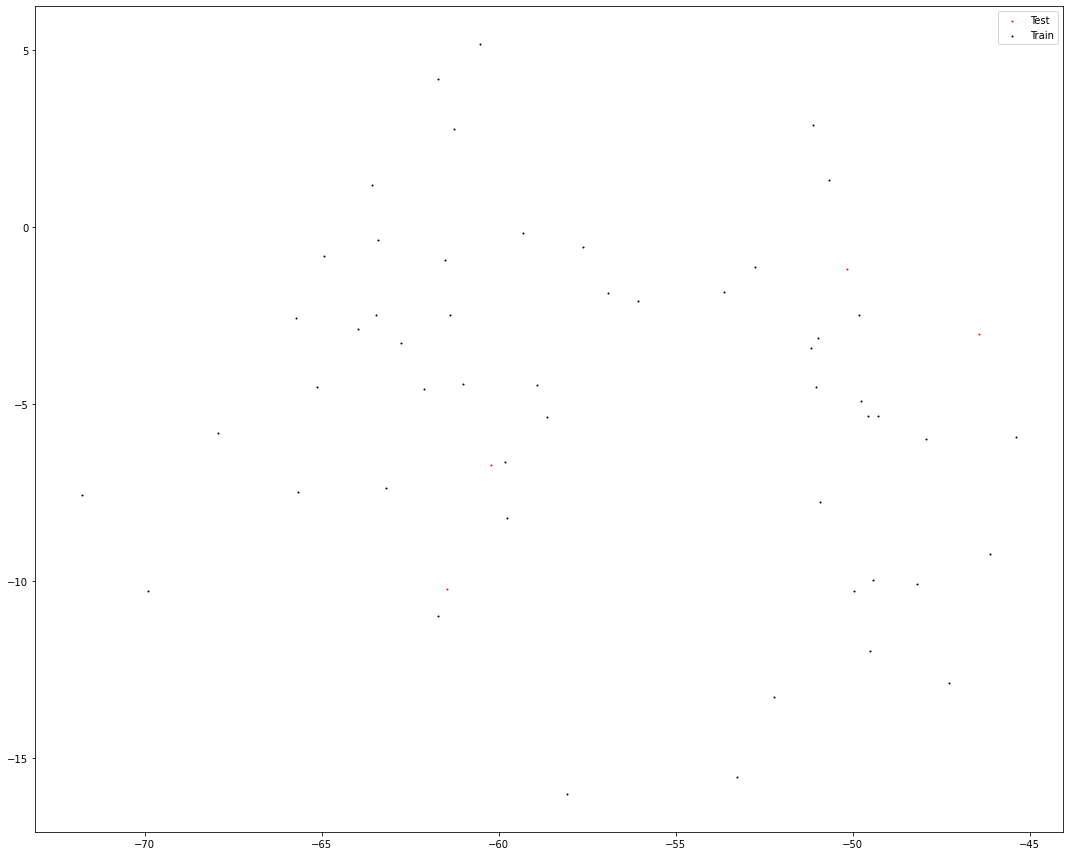

New cross validation indices generated and read in
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ...............model__max_depth=3;, score=-0.001 total time=   0.7s
[CV 2/5] END ...............model__max_depth=3;, score=-0.011 total time=   0.7s
[CV 3/5] END ...............model__max_depth=3;, score=-0.035 total time=   0.6s
[CV 4/5] END ...............model__max_depth=3;, score=-0.006 total time=   0.6s
[CV 5/5] END ...............model__max_depth=3;, score=-0.002 total time=   0.6s
randomforest MSE: 0.0006236527972744506
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ...............model__alpha=1e-15;, score=-0.198 total time=   0.0s
[CV 2/5] END ...............model__alpha=1e-15;, score=-1.385 total time=   0.0s
[CV 3/5] END ...............model__alpha=1e-15;, score=-0.083 total time=   0.0s
[CV 4/5] END ...............model__alpha=1e-15;, score=-0.254 total time=   0.0s
[CV 5/5] END ...............model__alpha=1e-15;, score=-0.47

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.063e-04, tolerance: 4.107e-05
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.373e-05, tolerance: 4.127e-05


[CV 5/5] END ...............model__alpha=0.001;, score=-0.088 total time=   0.0s
[CV 1/5] END ................model__alpha=0.01;, score=-0.001 total time=   0.0s
[CV 2/5] END ................model__alpha=0.01;, score=-0.017 total time=   0.0s
[CV 3/5] END ................model__alpha=0.01;, score=-0.035 total time=   0.0s
[CV 4/5] END ................model__alpha=0.01;, score=-0.194 total time=   0.0s
[CV 5/5] END ................model__alpha=0.01;, score=-0.346 total time=   0.0s
[CV 1/5] END ...................model__alpha=1;, score=-0.001 total time=   0.0s
[CV 2/5] END ...................model__alpha=1;, score=-0.006 total time=   0.0s
[CV 3/5] END ...................model__alpha=1;, score=-0.034 total time=   0.0s
[CV 4/5] END ...................model__alpha=1;, score=-0.000 total time=   0.0s
[CV 5/5] END ...................model__alpha=1;, score=-0.001 total time=   0.0s
[CV 1/5] END ...................model__alpha=5;, score=-0.001 total time=   0.0s
[CV 2/5] END ...............

invalid value encountered in true_divide


[CV 1/5] END model__max_depth=3, model__n_estimators=50;, score=-0.000 total time=   0.0s
[CV 2/5] END model__max_depth=3, model__n_estimators=50;, score=-0.010 total time=   0.0s
[CV 3/5] END model__max_depth=3, model__n_estimators=50;, score=-0.036 total time=   0.0s
[CV 4/5] END model__max_depth=3, model__n_estimators=50;, score=-0.003 total time=   0.0s
[CV 5/5] END model__max_depth=3, model__n_estimators=50;, score=-0.000 total time=   0.0s
[CV 1/5] END model__max_depth=3, model__n_estimators=100;, score=-0.000 total time=   0.1s
[CV 2/5] END model__max_depth=3, model__n_estimators=100;, score=-0.010 total time=   0.1s
[CV 3/5] END model__max_depth=3, model__n_estimators=100;, score=-0.035 total time=   0.1s
[CV 4/5] END model__max_depth=3, model__n_estimators=100;, score=-0.006 total time=   0.1s
[CV 5/5] END model__max_depth=3, model__n_estimators=100;, score=-0.000 total time=   0.1s
[CV 1/5] END model__max_depth=4, model__n_estimators=50;, score=-0.000 total time=   0.1s
[CV 2

X does not have valid feature names, but StandardScaler was fitted with feature names


[CV 5/5] END model__alpha=1e-05, model__hidden_layer_sizes=(100,);, score=-0.020 total time=   0.0s


X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
The default of 'normalize' wi

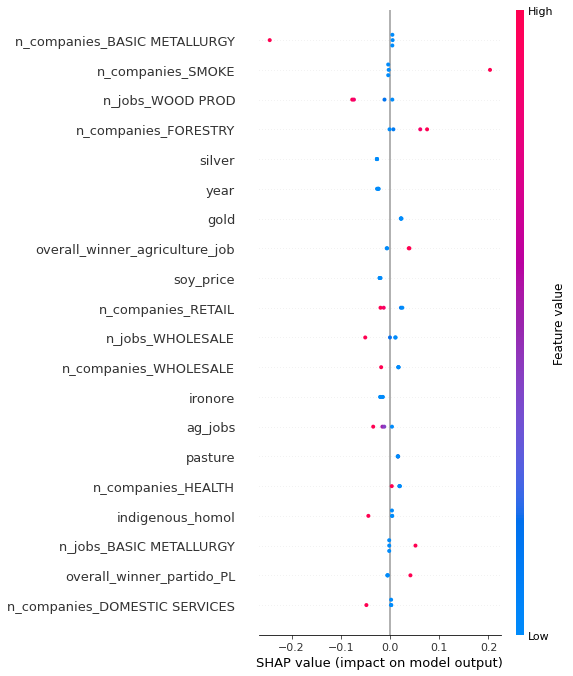

neuralnetwork MSE: 0.006011061842483334


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.303e-01, tolerance: 4.107e-05
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.062e-02, tolerance: 3.516e-05
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.690e-02, tolerance: 7.673e-06
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.007e-01, tolerance: 4.127e-05
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.164e-01, tolerance: 4.099e-05


Meta Data Shape:  (52, 4) (52,)


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.272e-01, tolerance: 4.168e-05
X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names


RandomForestRegressor: 0.001
Lasso: 0.002
GradientBoostingRegressor: 0.006
MLPRegressor: 0.006
MSE: 0.00041659145313625097


X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
X does not have valid feature names, but GradientBoostingRegressor was fitted with

superlearner MSE: 0.00041659145313625097


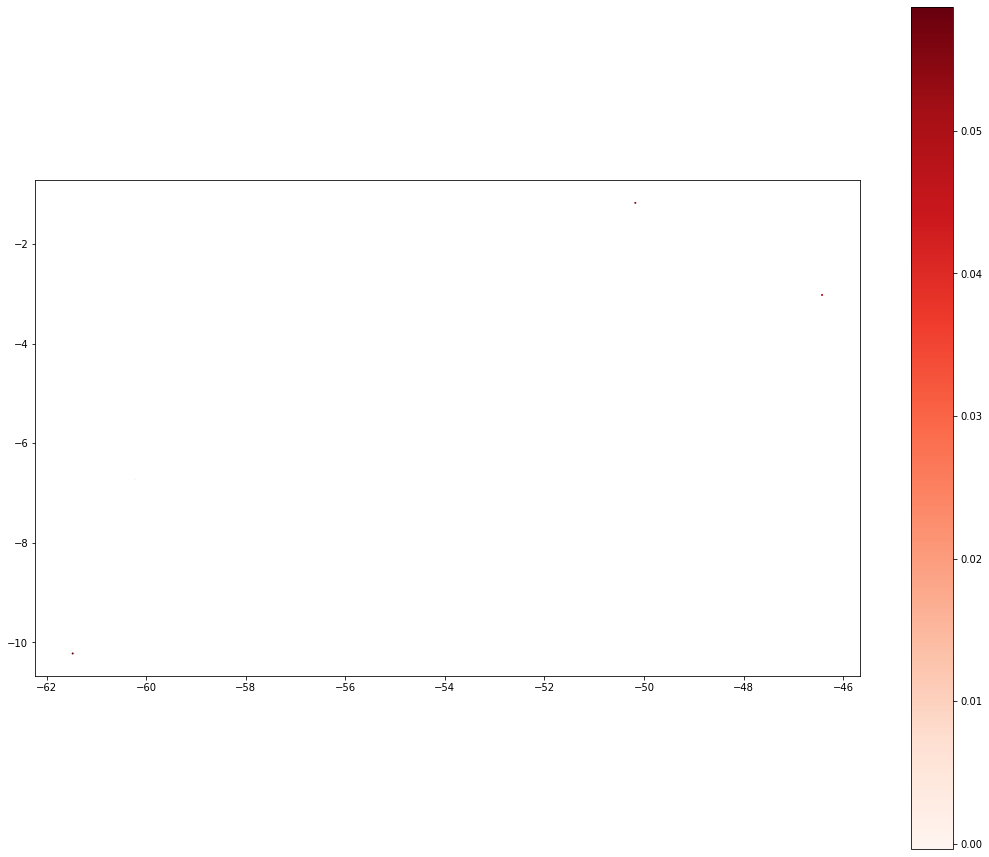

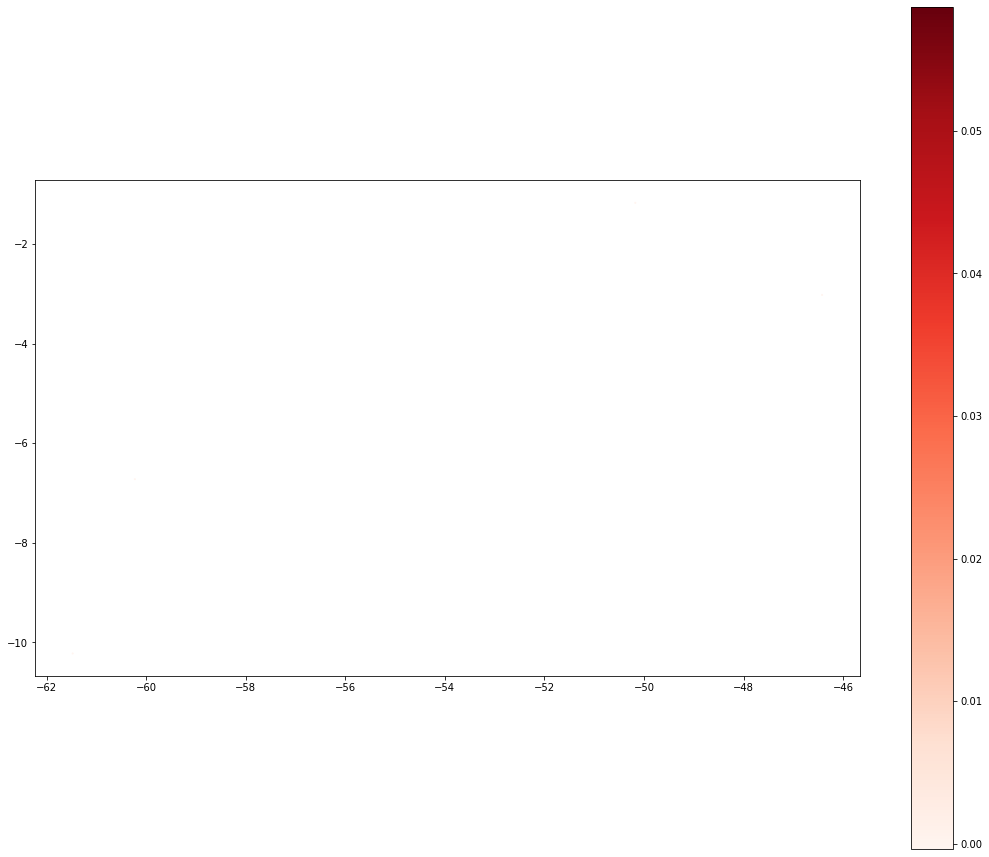

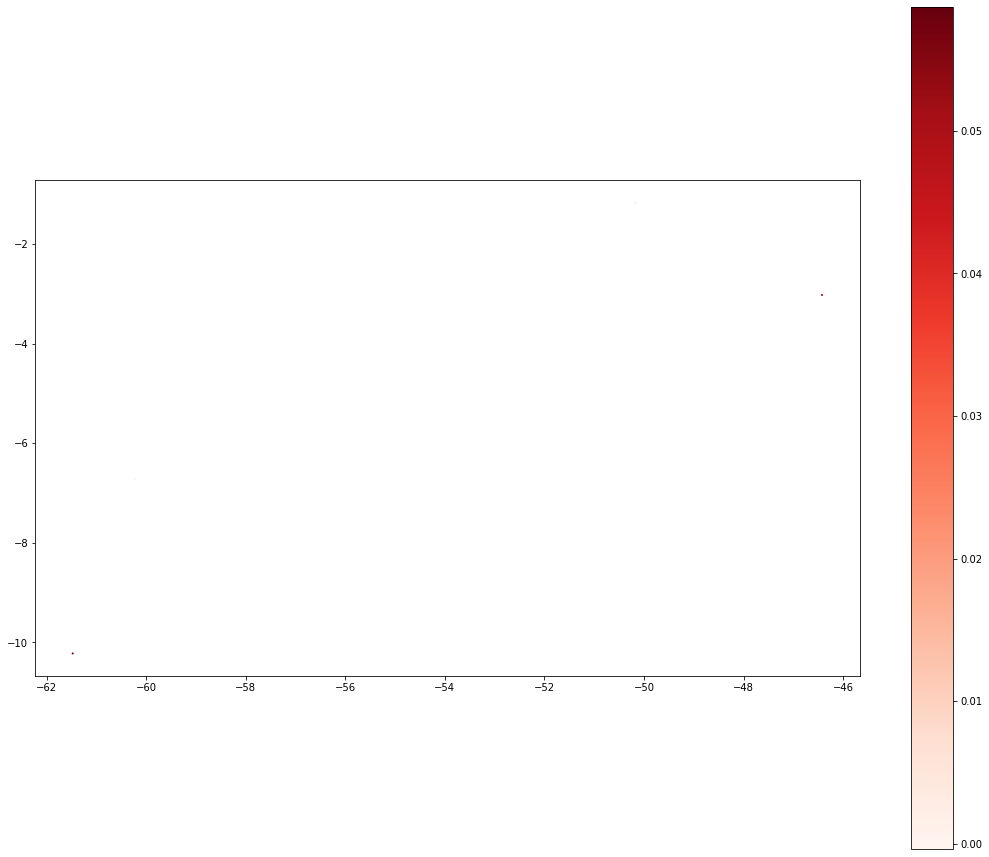

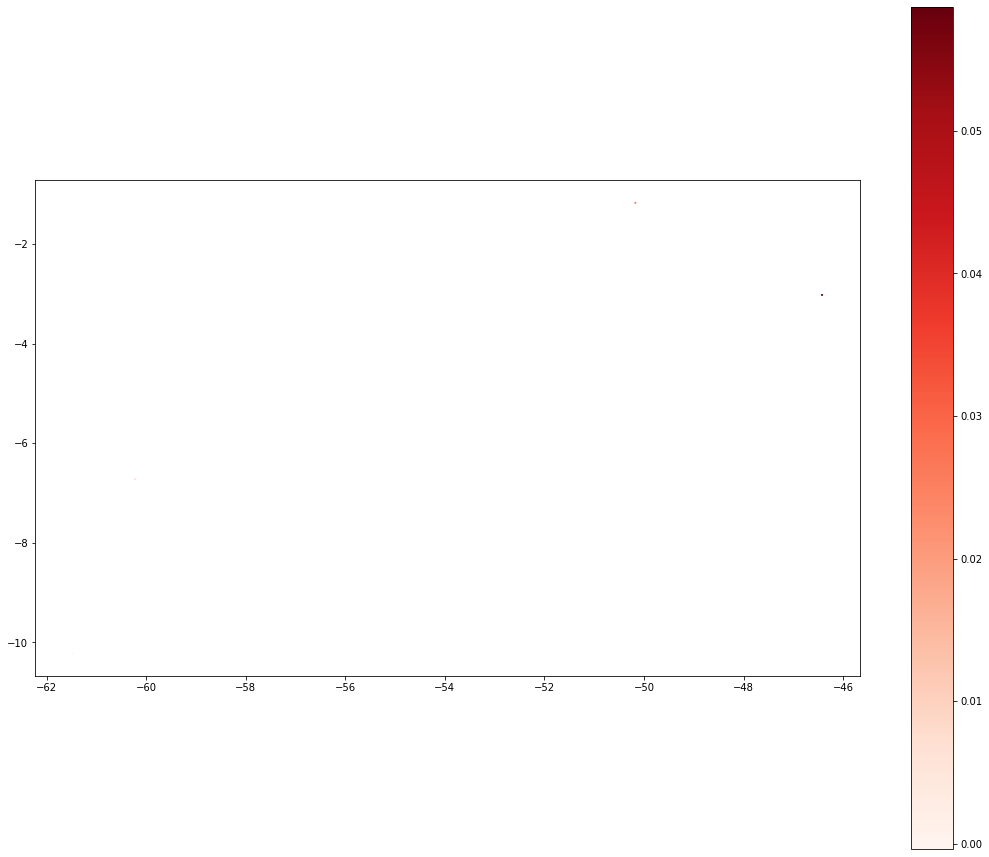

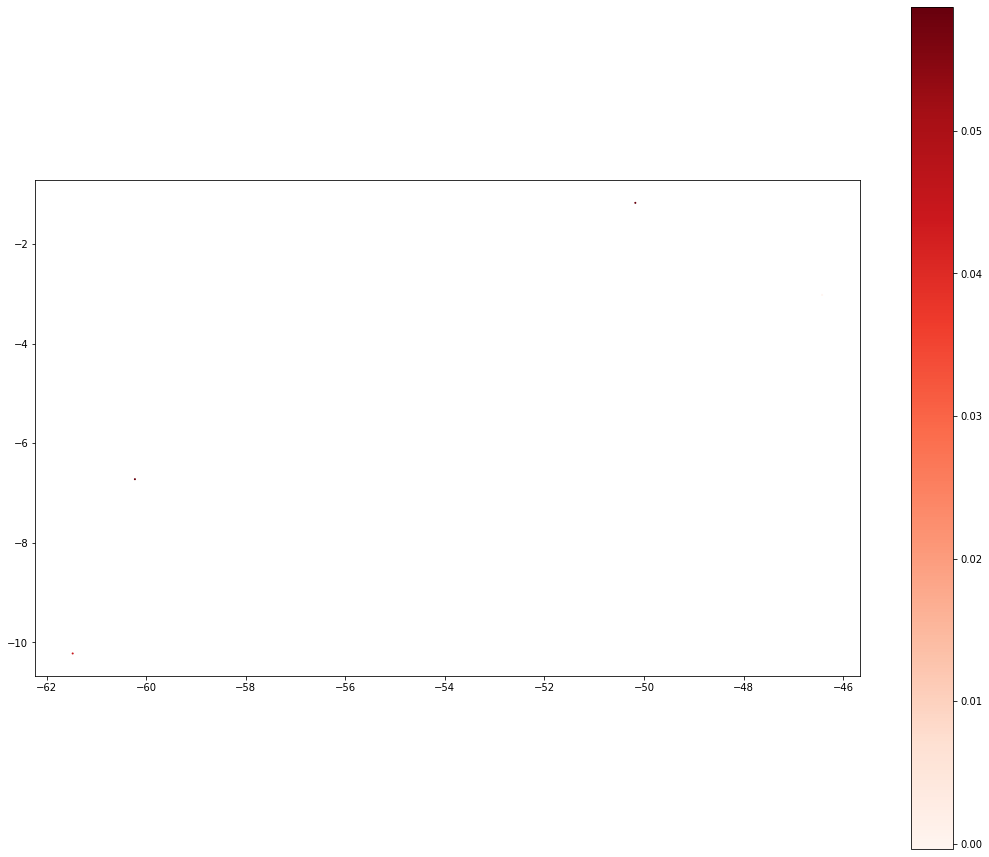

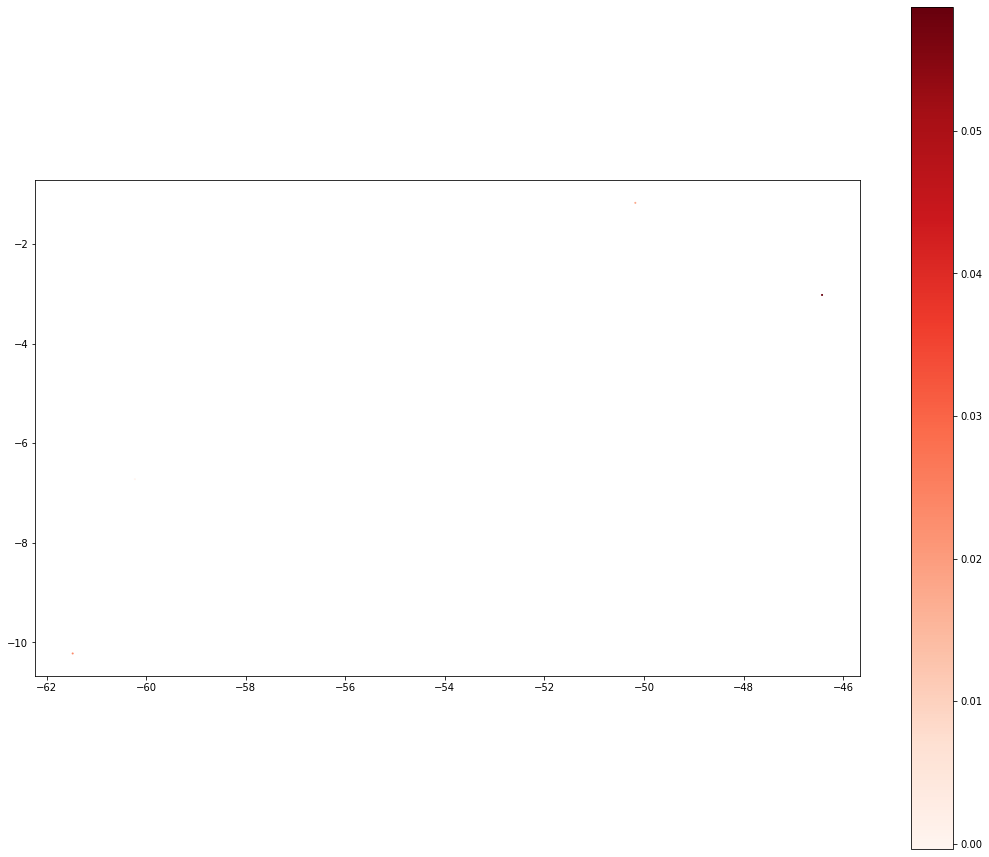

100%|██████████| 1/1 [01:07<00:00, 67.26s/it]


In [45]:
first_time = True

for this_start_year in tqdm([2004]):
    SUBSET = True
    SUBSET_SIZE = 100

    if first_time: 
        NEW_INDICES = True
        NEW_CV_INDICES = True
        first_time = False
        print('Set to create new indices for test train split and cross validation')
    else: 
        NEW_INDICES = False
        NEW_CV_INDICES = False
        print('Reading previous iteration test train split indices and cross validation indices')
    

    PLOT_ENTIRE_AREA = True
    PLOT_FOLDS = False

    START_YEAR_TRAIN = this_start_year
    NUMBER_YEARS_TRAIN = 3
    YEARS_TO_TRAIN = [START_YEAR_TRAIN + i  for i in range(NUMBER_YEARS_TRAIN + 1)]

    PREDICT_YEAR = START_YEAR_TRAIN + NUMBER_YEARS_TRAIN

    FOLDER_NAME = ''.join([f'{START_YEAR_TRAIN + i}_' for i in list(range(NUMBER_YEARS_TRAIN))]) + f'PREDICT_{PREDICT_YEAR}'

    FILE_PATH = f'FeatureImportanceResults/{FOLDER_NAME}/'

    print(f'Starting fit for {this_start_year}')

    setup_directory(FOLDER_NAME)
    
    df_full = get_full_data(START_YEAR_TRAIN, YEARS_TO_TRAIN)
    
    if SUBSET:
        df_full = df_full.sample(SUBSET_SIZE).reset_index(drop=True)

    X, Y = split_XY(df_full)

    if NEW_INDICES:
        train_inds, test_inds = get_new_test_train_inds(X, Y, df_full, FOLDER_NAME)
    if not NEW_INDICES:
        train_inds, test_inds = get_prev_test_train_inds(FOLDER_NAME)

    X_train, X_test, Y_train, Y_test = split_test_train(df_full, train_inds, test_inds, PREDICT_YEAR, PLOT_ENTIRE_AREA, NEW_INDICES, FILE_PATH, FOLDER_NAME)

    if NEW_CV_INDICES:
        muni_cv = get_new_cv(X_train, Y_train, FOLDER_NAME, PLOT_FOLDS, df_full, PREDICT_YEAR)
    if not NEW_CV_INDICES:
        muni_cv = get_prev_cv(FOLDER_NAME)

    get_null_count(X_train)
            
    X_train = X_train.drop('geometry', axis = 1)
    X_test = X_test.drop('geometry', axis = 1)

    #random forest
    randomforest_features_df = train_random_forest(X_train, Y_train, X_test)

    #lasso 
    lasso_features_df = train_lasso(X_train, Y_train, X_test)

    #gradient boosting
    gradient_boosting_features_df = train_gradient_boost(X_train, Y_train, X_test)
    
    #neural network
    nn_features_df = train_neural_network(X_train, Y_train, X_test)

    base_learners = get_base_learners(FOLDER_NAME)

    #super learner ensemble
    base_learners, super_learner_features_df = train_super_learner( X_train, Y_train, X_test)

    yhat_list = get_yhat_list(FOLDER_NAME)
    
    #visualize
    visualize_predictions(yhat_list, Y_test, FILE_PATH, FOLDER_NAME)
    